# The material presented in this jupyter notebook is part of the "ECE 685: Introduction to Deep Learning" course offered at Duke University.

# Session: Fall 2023

# Part 10a: Generative Models - VAEs

## Variational Autoencoders (VAEs)

### Summary:

A VAE uses two neural networks,

* Encoder ($q_{\phi}(z|x)$): Encodes X into Z. To get Z, we do the following
    * Encoder outputs $\mu$ and log-variance (instead of $\sigma$).
    * Sample $z \sim Normal(\mu, \sigma^2)$ using reparameterization trick.
    
* Decoder ($p_{\theta}(x|z)$): Decode from Z to X.

To train a VAE, we maximize the Evidence Lower Bound (ELBO):

$$ELBO (x) = \mathbb{E}_{q_{\phi}(z|x)}\log(p_{\theta}(x|z)) - \text{KL}[q_{\phi}(z|x) || p(z)]$$

![](https://drive.google.com/uc?export=view&id=1y3vpP40UFYkYJ3VclaxWg8HtHv7cTxQ7)

### Import Modules

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

### Prepare Dataloader

In [6]:
batch_size = 128

train_set,test_set,train_loader,test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor()])

train_set['mnist'] = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set['mnist'] = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader['mnist'] = torch.utils.data.DataLoader(train_set['mnist'], batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['mnist'] = torch.utils.data.DataLoader(test_set['mnist'], batch_size=batch_size, shuffle=False, num_workers=0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

100%|██████████| 9912422/9912422 [00:00<00:00, 173214808.70it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 73818216.83it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 74943015.94it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15744238.65it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
class VAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)
        self.fc22 = nn.Linear(n_hid, z_dim)
        self.fc3 = nn.Linear(z_dim, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)

    def encode(self, x):
        """Encoder forward pass.

        Args:
            x: Input image

        Returns:
            mu: self.fc21(h1)
            logvar: self.fc22(h1)
        """

        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        """Implements: z = mu + epsilon*stdev.

        Args:
            mu: mean
            logvar: log of variance

        Return:
            z: sample from Normal(mu, var).

            Epsilon is sampled from standard normal distribution.
            \epsilon \sim Normal(0, 1)
        """

        stdev = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev

    def decode(self, z):
        """Decoder forward pass.

        Args:
            z: Batch of latent representations.

        Returns:
            x_recon: Image probabilities.
        """

        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        """Implements forward pass of VAE.

        Args:
            x: Batch of input images.

        Returns:
            x_recon: Batch of reconstructed images.
            mu: Batch of mean vectors
            logvar: Batch of log-variance vectors
        """

        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    """Computes the loss = -ELBO = Negative Log-Likelihood + KL Divergence.

    Args:
        recon_x: Decoder output.
        x: Ground truth.
        mu: Mean of Z
        logvar: Log-Variance of Z

        p(z) here is the standard normal distribution with mean 0 and identity covariance.
    """

    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # BCE = -Negative Log-likelihood
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence b/w q_\phi(z|x) || p(z)
    return BCE + KLD

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0),-1)
        data = data.to(device)

        optimizer.zero_grad()
        output, mu, logvar = model(data)
        loss = loss_function(output, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))
    return train_loss

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0),-1)
            data = data.to(device)
            output, mu, logvar = model(data)
            loss = loss_function(output, data, mu, logvar)
            test_loss += loss.item() # sum up batch loss
    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}'.format(
        epoch, test_loss))
    return test_loss

In [9]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer

In [10]:
seed = 1
data_name = 'mnist'
optimizer_name = 'Adam'

num_epochs = 10
lr = 0.001
n_in = 28*28
n_hid = 400
z_dim = 20

device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [11]:
vae = VAE(n_in, n_hid, z_dim).to(device)

optimizer = make_optimizer(optimizer_name, vae, lr=lr)

for epoch in range(1, num_epochs + 1):
    train(vae, device, train_loader[data_name], optimizer, epoch)

test(vae, device, test_loader[data_name], epoch)

Train(1)[0%]: Loss: 70476.3125
Train(1)[50%]: Loss: 24609.3406
Train(1)[100%]: Loss: 21086.1990
Train(2)[0%]: Loss: 15917.4707
Train(2)[50%]: Loss: 15987.5040
Train(2)[100%]: Loss: 15637.2177
Train(3)[0%]: Loss: 14711.9902
Train(3)[50%]: Loss: 14890.4378
Train(3)[100%]: Loss: 14713.2618
Train(4)[0%]: Loss: 13902.9971
Train(4)[50%]: Loss: 14381.4798
Train(4)[100%]: Loss: 14299.9077
Train(5)[0%]: Loss: 13727.0518
Train(5)[50%]: Loss: 14114.0887
Train(5)[100%]: Loss: 14063.7743
Train(6)[0%]: Loss: 13698.5859
Train(6)[50%]: Loss: 13949.9133
Train(6)[100%]: Loss: 13913.8716
Train(7)[0%]: Loss: 13571.7988
Train(7)[50%]: Loss: 13833.1916
Train(7)[100%]: Loss: 13799.5319
Train(8)[0%]: Loss: 13976.9189
Train(8)[50%]: Loss: 13732.9786
Train(8)[100%]: Loss: 13720.8954
Train(9)[0%]: Loss: 13670.7461
Train(9)[50%]: Loss: 13612.5341
Train(9)[100%]: Loss: 13645.4053
Train(10)[0%]: Loss: 13020.0400
Train(10)[50%]: Loss: 13606.8493
Train(10)[100%]: Loss: 13592.1457
Test(10): Loss: 13500.6171


13500.61709375

In [12]:
def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()

    fig, axes = plt.subplots(1,2, figsize=(20,10))
    axes[0].imshow(np.transpose(npimg1, (1,2,0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1,2,0)), interpolation='nearest')
    fig.show()

In [13]:
data,_ = next(iter(test_loader[data_name]))
data = data[:32]
data_size = data.size()
data = data.view(data.size(0),-1).to(device)
output, _, _ = vae(data)
output = output.detach()

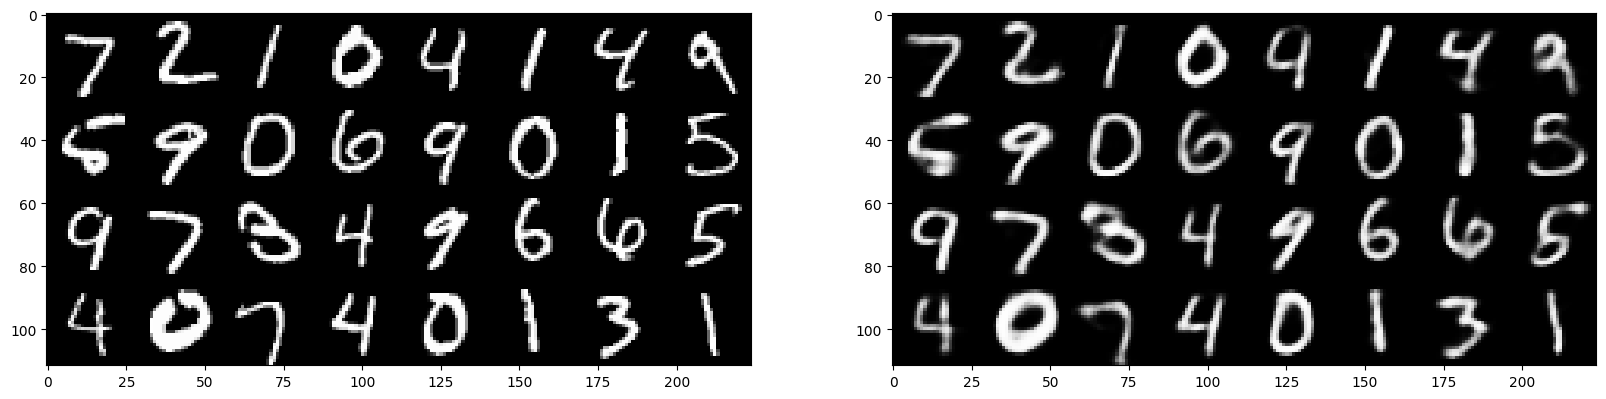

In [14]:
show(make_grid(data.reshape(data_size), padding=0), make_grid(output.reshape(data_size), padding=0))

In [15]:
X_test, Y_test = next(iter(test_loader[data_name]))
X_batch, Y_batch = X_test[:128], Y_test[:128]

In [16]:
data_size = X_test.size()
data = X_test.view(X_test.size(0),-1).to(device)
Z, _ = vae.encode(data)

In [17]:
def get_centroid(x):
    """Computes the centroid of images in the latent space.

    Args:
        x: torcch.Tensor of shape: batch x 1 x 28 x 28

    Returns:
        z_centroid: Centroid in latent space.
    """

    data_size = x.size()
    data = x.view(x.size(0),-1).to(device)
    Z, _ = vae.encode(data)
    Z_centroid = Z.mean(axis=0)

    return Z_centroid

def get_a2b(a_label: int, b_label: int):
    """Computes the vector in latent space from centroid of a to centroid of b.

    Args:
        a_label: Class `a`
        b_label: Class `b`

    Returns:
        z_a2b: Vector from centroid of `a` to centroid of `b`.
    """

    x_a = X_test[Y_test == a_label]
    x_b = X_test[Y_test == b_label]

    z_a = get_centroid(x_a)
    z_b = get_centroid(x_b)
    z_a2b = z_b - z_a
    return z_a2b

def interpolate(a_label = 0):
    """Interpolate in latent space from one class to another class."""

    all_classes = np.arange(0, 10)
    all_classes = np.delete(all_classes, a_label)
    z_a2b_all = []
    for b_label in all_classes:
        z_a2b_all.append(get_a2b(a_label, b_label))

    x_a = X_test[Y_test == a_label]
    data_size = x_a.size()
    data = x_a.view(x_a.size(0),-1).to(device)
    z_a, _ = vae.encode(data)
    z_in = z_a[0]

    x_interpolated = []
    for z_a2b in z_a2b_all:
        for alpha in np.arange(0, 2, 0.2):
            z = z_in + alpha*z_a2b
            x_vae = vae.decode(z).detach()
            x_interpolated.append(x_vae)

    nrow = len(x_interpolated)
    x_all = torch.stack(x_interpolated)
    img = make_grid(x_all.reshape((nrow, 1, 28, 28)), padding=0, nrow=nrow//9)
    npimg = img.cpu().numpy()

    return npimg


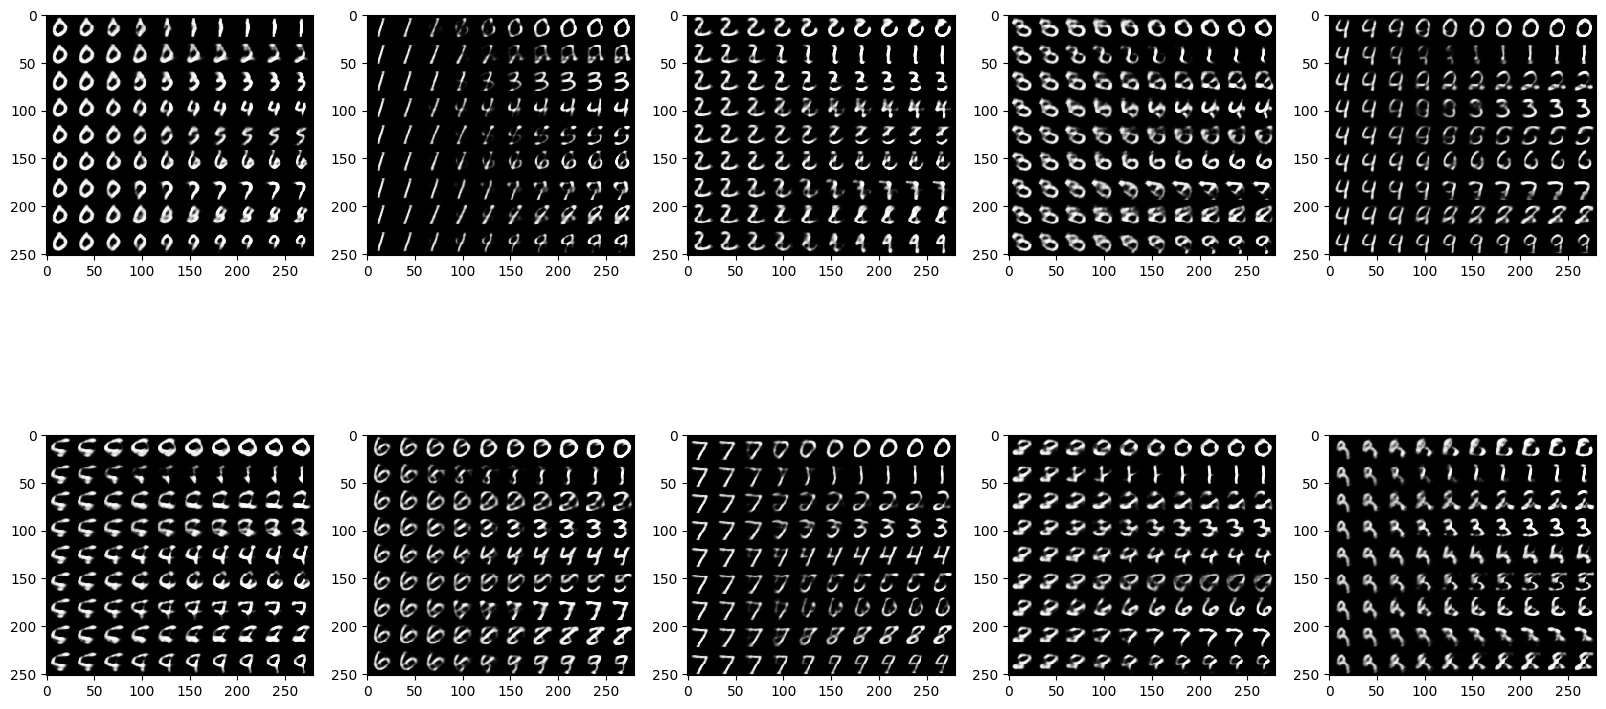

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for a_label, ax in enumerate(axes.flat):
    img = interpolate(a_label=a_label)
    ax.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')

fig.show()
